In [146]:
import tensornetwork as tn
import numpy as np
import matplotlib.pyplot as plt

In [369]:

def initialize_state(n_qubits):
    """Initialize the quantum state to an equal superposition state."""
    state = np.ones((2,) * n_qubits) / np.sqrt(2**n_qubits)
    return state

def apply_gate(state, gate, qubits, target_qubit):
    """Apply a single-qubit gate to a tensor network state."""
    gate = gate.reshape((2, 2))
    axes = list(range(len(state.shape)))
    axes[target_qubit] = axes[-1]
    axes[-1] = target_qubit
    state = np.tensordot(state, gate, axes=(target_qubit, 0))
    return np.moveaxis(state, -1, target_qubit)

def apply_oracle(state, target_state):
    """Apply the oracle by flipping the phase of the target state."""
    shape = state.shape
    indices = tuple(int(b) for b in format(target_state, f'0{len(shape)}b'))
    state[indices] *= -1
    return state

def apply_diffusion(state):
    """Apply the diffusion operator."""
    n_qubits = len(state.shape)
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    X = np.array([[0, 1], [1, 0]])

    for qubit in range(n_qubits):
        state = apply_gate(state, H, n_qubits, qubit)

    for qubit in range(n_qubits):
        state = apply_gate(state, X, n_qubits, qubit)

    # Multi-controlled Z gate, approximated by flipping all but one qubit and applying Z
    state = apply_gate(state, np.diag([1, -1]), n_qubits, n_qubits - 1)

    for qubit in range(n_qubits - 1):
        state = apply_gate(state, X, n_qubits, qubit)

    for qubit in range(n_qubits):
        state = apply_gate(state, H, n_qubits, qubit)

    return state

def measure_state(state):
    """Measure the quantum state to find the most probable state."""
    probabilities = np.abs(state)**2
    most_probable_state = np.unravel_index(np.argmax(probabilities), state.shape)
    return most_probable_state

# Number of qubits
n_qubits = 2

# Initialize the quantum state
state = initialize_state(n_qubits)

# Target state to search for (in decimal representation)
target_state = 1  # Corresponds to the binary state '101'

# Number of Grover iterations
num_iterations = int(np.floor(np.pi / 4 * np.sqrt(2**n_qubits)))

# Perform Grover iterations
for _ in range(num_iterations):
    state = apply_oracle(state, target_state)
    state = apply_diffusion(state)

# Measure the final state
result = measure_state(state)
result_bin = ''.join(map(str, result))
print("Measurement result: ", result_bin)


Measurement result:  00


In [370]:
state

array([[ 0.5,  0.5],
       [-0.5,  0.5]])

In [328]:
state = initialize_state(n_qubits)


(2, 2, 2)

In [329]:
apply_oracle(state, 5)

array([[[ 0.35355339,  0.35355339],
        [ 0.35355339,  0.35355339]],

       [[ 0.35355339, -0.35355339],
        [ 0.35355339,  0.35355339]]])

In [286]:
q0 = np.array([1, 0], dtype=complex)
q1 = np.array([1, 0], dtype=complex)

I = np.array(
    [
        [1,0],
        [0,1]
    ],
    dtype=complex
)

X = np.array(
    [
        [0,1],
        [1,0]
    ],
    dtype=complex
)

H = 1/np.sqrt(2) * np.array(
    [
        [1,1],
        [1,-1]
    ],
    dtype=complex
)
# |00> -> H0 -> X1

a = H @ q0
print('a:', a)

b = X @ q1
print('b:', b)


np.kron(a,b)

a: [0.70710678+0.j 0.70710678+0.j]
b: [0.+0.j 1.+0.j]


array([0.        +0.j, 0.70710678+0.j, 0.        +0.j, 0.70710678+0.j])

In [322]:
a= np.tensordot(q0, H, axes=(0, 1)).reshape(2,1)
b= np.tensordot(q0, H, axes=(0,1)).reshape(2,1)

c = np.tensordot(a,b, axes=(1,1)).reshape(-1)

# apply oracle
c[-1] =  c[-1] * -1

c

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

In [316]:
def string2state(state: str) -> np.array:
    qubits = []
    for qubit in state:
        if qubit == '0':
            qubits.append(np.array([1, 0], dtype=complex))
        if qubit == '1':
            qubits.append(np.array([0, 1], dtype=complex))

    result = qubits[0]

    for i in range(1, len(qubits)):
        result = np.kron(result, qubits[i])

    return result


o_state = string2state('11')


In [317]:
for i in o_state:
    print(i == 1)

False
False
False
True


In [ ]:
np.tensordot

In [297]:
np.kron(a,b)

array([0.        +0.j, 0.70710678+0.j, 0.        +0.j, 0.70710678+0.j])

# Diff between direct matrix multiplication and tensor networks

In [57]:

# Define a 3-qubit state vector |psi>
n_qubits = 3
# Parameters
dim = 2 ** n_qubits
psi = np.random.rand(dim) + 1j * np.random.rand(dim)  # Random complex state vector
psi /= np.linalg.norm(psi)  # Normalize the state vector

# Define a random 8x8 unitary matrix U
U = np.random.rand(dim, dim) + 1j * np.random.rand(dim, dim)
U, _ = np.linalg.qr(U)  # Make it unitary

# Apply the gate to the state
psi_prime = np.dot(U, psi)

print("Original state vector (|psi>):\n", psi)
print("New state vector (|psi'>) after applying U:\n", psi_prime)


Original state vector (|psi>):
 [0.23656305+0.33878388j 0.02919052+0.0816522j  0.35002621+0.16469965j
 0.02728614+0.36609154j 0.15338857+0.31260867j 0.16593072+0.27189393j
 0.27528525+0.34073908j 0.34600488+0.05492129j]
New state vector (|psi'>) after applying U:
 [ 0.20062623+0.31098263j  0.1085869 +0.12939018j  0.08366832-0.14559652j
 -0.10617285-0.31863287j -0.04690053-0.28283012j -0.53767042-0.1916873j
  0.04651939-0.45969858j  0.26827004-0.0050968j ]


In [129]:
np.random.rand(bond_dim, 2, bond_dim) + 1j * np.random.rand(bond_dim, 2, bond_dim)

array([[[0.77615957+0.53477418j, 0.8939057 +0.82676344j],
        [0.54489424+0.33994098j, 0.42251417+0.03319409j]],

       [[0.2183227 +0.02457661j, 0.82666194+0.04603414j],
        [0.64704707+0.247914j  , 0.74238206+0.63089311j]]])

In [130]:
np.random.rand(bond_dim, 2) + 1j * np.random.rand(bond_dim, 2)

array([[0.407862  +0.76533463j, 0.06642752+0.32900599j],
       [0.86972971+0.56881453j, 0.5411513 +0.86402142j]])

In [154]:
# Import necessary libraries
import numpy as np

# Define a function to create a random MPS representation for a 3-qubit state
def create_random_mps(n_qubits, bond_dim):
    # Initialize list to store MPS tensors
    mps = []
    # Create the first tensor (rank-1 tensor)
    mps.append(np.random.rand(2, bond_dim) + 1j * np.random.rand(2, bond_dim))
    # Create the middle tensors (rank-3 tensors)
    for _ in range(1, n_qubits - 1):
        mps.append(np.random.rand(bond_dim, 2, bond_dim) + 1j * np.random.rand(bond_dim, 2, bond_dim))
    # Create the last tensor (rank-2 tensor)
    mps.append(np.random.rand(bond_dim, 2) + 1j * np.random.rand(bond_dim, 2))
    return mps

# Define a function to reconstruct the state vector from the MPS
def mps_to_state_vector(mps):
    state_vector = mps[0]
    for tensor in mps[1:]:
        state_vector = np.tensordot(state_vector, tensor, axes=(-1, 0))
    return state_vector.reshape(-1)


# Create a random MPS
mps = create_random_mps(n_qubits, 1)

# Reconstruct the state vector from the MPS
psi_mps = mps_to_state_vector(mps)

print("MPS representation of the state vector (|psi_mps>):\n", psi_mps)


MPS representation of the state vector (|psi_mps>):
 [-1.10617237+0.00961269j -0.476956  +0.47312585j -0.63541992+0.57084795j
 -0.03431663+0.5176165j  -1.14002472+0.22161219j -0.40180297+0.57966736j
 -0.54667873+0.71086799j  0.0636329 +0.54088521j]


In [159]:
psi_mps.shape

(8,)

In [79]:
mps[2]

array([[0.24835837+0.65763248j, 0.94471215+0.40884161j],
       [0.64321282+0.24786358j, 0.25157088+0.57166541j]])

In [134]:
import numpy as np

# Define the MPS tensors
A1 = np.array([[1, 0], [0, 1]], dtype=complex)  # Shape (2, 2)
A2 = np.zeros((2, 2, 2), dtype=complex)         # Shape (2, 2, 2)
A2[:, :, 0] = np.array([[1, 0], [0, 0]])
A2[:, :, 1] = np.array([[0, 0], [0, 1]])
A3 = np.array([[1, 0], [0, 1]], dtype=complex)  # Shape (2, 2)

# List of tensors forming the MPS
mps = [A1, A2, A3]

# Function to reconstruct the state vector from the MPS tensors
def mps_to_state_vector(mps):
    state_vector = mps[0]
    for tensor in mps[1:]:
        state_vector = np.tensordot(state_vector, tensor, axes=(-1, 0))
    return state_vector.reshape(-1)

# Reconstruct the state vector from the MPS
psi_mps = mps_to_state_vector(mps)

# Normalize the state vector
psi_mps /= np.linalg.norm(psi_mps)

print("Reconstructed state vector from MPS:\n", psi_mps)
print("Expected state vector:\n", np.array([1, 0, 0, 0, 0, 0, 0, 1], dtype=complex) / np.sqrt(2))


Reconstructed state vector from MPS:
 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Expected state vector:
 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [218]:
# Define the MPS tensors
A1 = np.array([[1, 0], [0, 1]], dtype=complex)  # Shape (2, 2)
A2 = np.zeros((2, 2, 2), dtype=complex)         # Shape (2, 2, 2)
A2[:, :, 0] = np.array([[1, 0], [0, 0]])
A2[:, :, 1] = np.array([[0, 0], [0, 1]])
A3 = np.zeros((2, 2, 2), dtype=complex)         # Shape (2, 2, 2)
A3[:, :, 0] = np.array([[1, 0], [0, 0]])
A3[:, :, 1] = np.array([[0, 0], [0, 1]])
A4 = np.array([[1, 0], [0, 1]], dtype=complex)  # Shape (2, 2)

# List of tensors forming the MPS
mps = [A1, A2, A3, A4]

# Function to reconstruct the state vector from the MPS tensors
def mps_to_state_vector(mps):
    state_vector = mps[0]
    for tensor in mps[1:]:
        state_vector = np.tensordot(state_vector, tensor, axes=(-1, 0))
    return state_vector.reshape(-1)

# Reconstruct the state vector from the MPS
psi_mps = mps_to_state_vector(mps)

# Normalize the state vector
psi_mps /= np.linalg.norm(psi_mps)

print("Reconstructed state vector from MPS:\n", psi_mps)
print("Expected state vector:\n", np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=complex) / np.sqrt(2))


Reconstructed state vector from MPS:
 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Expected state vector:
 [0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


In [237]:
(A2[-1] @ A3[0])

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [235]:
np.tensordot(A2, A3, axes=(-1,0))

array([[[[1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]]],


       [[[0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j]]]])

In [259]:
import numpy as np

# Initialize the MPS tensors for |00>
# First qubit tensor: encoding |0>
A1 = np.array([[1], [0]], dtype=complex)  # Shape (2, 1)

# Second qubit tensor: encoding |0>
A2 = np.array([[[1, 0]]], dtype=complex)  # Shape (1, 2, 1)

# Apply Hadamard gate to the first qubit
H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
A1 = np.tensordot(H, A1, axes=(1, 0))  # Shape (2, 2)

# Apply CNOT gate from qubit 0 to qubit 1
# CNOT gate in tensor form
CNOT = np.array([[[[1, 0], [0, 0]], [[0, 0], [0, 1]]],
                 [[[0, 0], [1, 0]], [[0, 1], [0, 0]]]], dtype=complex)

# Reshape A1 to be compatible with the CNOT operation
A1 = A1.reshape(2, 2, 1)

# Apply the CNOT gate
A2 = np.tensordot(CNOT, A2, axes=([2, 3], [1, 0]))  # Shape (2, 2, 2)

# Reorder dimensions of A2 to fit MPS structure
A2 = A2.transpose(0, 1, 2)

# List of tensors forming the MPS
mps = [A1, A2]

# Function to reconstruct the state vector from MPS tensors
def mps_to_state_vector(mps):
    state_vector = mps[0]
    for tensor in mps[1:]:
        state_vector = np.tensordot(state_vector, tensor, axes=(-1, 0))
    return state_vector.reshape(-1)

# Reconstruct the state vector from the MPS
psi_mps = mps_to_state_vector(mps)

# Normalize the state vector
psi_mps /= np.linalg.norm(psi_mps)

print("Reconstructed state vector from MPS:\n", psi_mps)
expected_state = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=complex)
print("Expected state vector:\n", expected_state)


ValueError: cannot reshape array of size 2 into shape (2,2,1)

In [264]:
def apply_gate(qubit_edges, gate, operating_qubits):
  op = tn.Node(gate)
  for i, bit in enumerate(operating_qubits):
    tn.connect(qubit_edges[bit], op[i])
    qubit_edges[bit] = op[i + len(operating_qubits)]

# These are just numpy arrays of the operators.
H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
CNOT = np.zeros((2, 2, 2, 2), dtype=complex)
CNOT[0][0][0][0] = 1
CNOT[0][1][0][1] = 1
CNOT[1][0][1][1] = 1
CNOT[1][1][1][0] = 1
all_nodes = []
# NodeCollection allows us to store all of the nodes created under this context.
with tn.NodeCollection(all_nodes):
  state_nodes = [
      tn.Node(np.array([1.0 + 0.0j, 0.0 + 0.0j],)) for _ in range(2)
  ]
  qubits = [node[0] for node in state_nodes]
  apply_gate(qubits, H, [0])
  apply_gate(qubits, CNOT, [0, 1])
# We can contract the entire tensornetwork easily with a contractor algorithm
result = tn.contractors.optimal(
    all_nodes, output_edge_order=qubits)
print(result.tensor) # array([0.707+0.j, 0.0+0.j], [0.0+0.j, 0.707+0.j])

[[0.70710678+0.j 0.        +0.j]
 [0.        +0.j 0.70710678+0.j]]


In [274]:
qubits[0]


Edge(Dangling Edge)[0] 

In [258]:
psi_mps

array([0.        +0.j, 0.70710678+0.j, 0.        +0.j, 0.70710678+0.j])

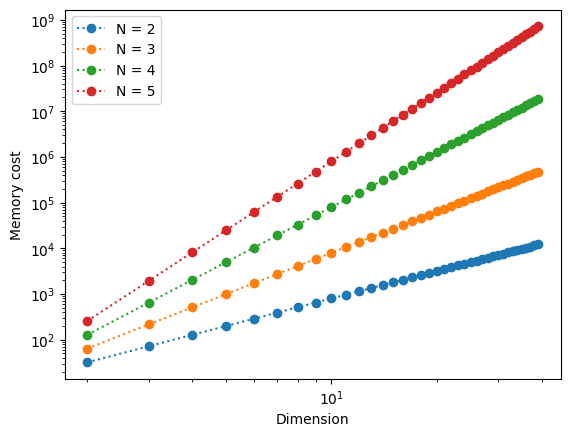

In [147]:
def create_tensor(dimension, rank):
  '''Constructs a tensor of a given rank with random integers'''
  dim_list = tuple([dimension for _ in range(rank)])
  return np.random.random_sample(dim_list)

ranks = range(2,6)
dimensions = range(2,40)

for rank in ranks:
  memory = []
  for dim in dimensions:
      tensor = create_tensor(dim, rank)
      component = tuple(np.random.randint(0, dim, rank))
      memory.append(np.sum([x.nbytes for x in tensor]))
      data = tensor[component]
  plt.loglog(dimensions, memory,'o',ls=':', label = f'N = {rank}')

plt.legend()
plt.xlabel('Dimension')
plt.ylabel('Memory cost')
plt.show()

In [163]:
# Retrieving a component

def block(*dimensions):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    size = tuple([x for x in dimensions])
    return np.random.random_sample(size)

def create_MPS(rank, dim, bond_dim):
    '''Build the MPS tensor'''
    mps = [
        tn.Node( block(dim, bond_dim) )] \
    +[tn.Node( block(bond_dim, dim, bond_dim)) for _ in range(rank-2)] + \
        [tn.Node( block(bond_dim, dim) )
        ]

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank-1):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

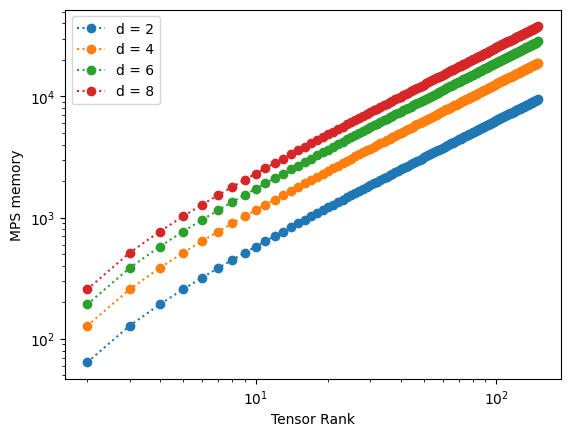

In [165]:
dimensions = range(2,9,2)
MPS_ranks = range(2,150)
MPS_memory = []

for dim in dimensions:
    bond_dim = 2
    MPS_memory = []
    for i in range(len(MPS_ranks)):
        rank = MPS_ranks[i]

        # Creating the MPS state:
        ##################################################################
        mps_nodes, mps_edges = create_MPS(rank, dim, bond_dim)
        MPS_memory.append(np.sum([x.tensor.nbytes for x in mps_nodes]))

    # Plot Results
    plt.loglog(MPS_ranks, MPS_memory, 'o',ls=':', label = f'd = {dim}')

plt.legend()
plt.xlabel('Tensor Rank')
plt.ylabel('MPS memory')

plt.show()

In [179]:
mps_nodes[0].tensor.shape

(8, 2)

In [153]:
mps_nodes[0]

Node
(
name : '__unnamed_node__',
tensor : 
array([[0.90999135, 0.86391065],
       [0.53113305, 0.12459112],
       [0.719546  , 0.77002917],
       [0.90259764, 0.32934341],
       [0.71547161, 0.55855891],
       [0.36522339, 0.62434129],
       [0.16874696, 0.05981373],
       [0.26494073, 0.81680409]]),
edges : 
[
Edge(Dangling Edge)[0] 
, 
Edge('__unnamed_node__'[1] -> '__unnamed_node__'[0] )
] 
)

In [33]:
def decimal_to_binary(num: int) -> str:
    return str(bin(num))[2:]

def pad_binary(binary_str: str, length: int) -> str:
    return '0'*(length-len(binary_str)) + binary_str

In [38]:
n = 4
N = 2**n
for i in range(N):
    print(pad_binary(decimal_to_binary(i), n))

0000
0001
0010
0011
0100
0101
0110
0111
1000
1001
1010
1011
1100
1101
1110
1111


In [17]:
2 / 2**1

1.0

In [5]:
a = np.array([1.0 + 0.0j, 0.0 + 0.0j])
b = np.array([0.0 + 0.0j, 1.0 + 0.0j])

h = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
I = np.array([[1, 0], [0, 1]])

a @ h @ h

array([1.+0.j, 0.+0.j])

In [10]:
u = np.kron(I, h)
c = np.kron(a, b)


u@c

array([ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j,  0.        +0.j])

In [12]:
u

array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.70710678, -0.70710678,  0.        , -0.        ],
       [ 0.        ,  0.        ,  0.70710678,  0.70710678],
       [ 0.        , -0.        ,  0.70710678, -0.70710678]])

In [180]:
state = tn.Node(np.array([1.0 + 0.0j, 0.0 + 0.0j]))
qubit_in = state[0]

# This node represents the Hadamard gate we wish to perform
# on this qubit.
hadamard = tn.Node(np.array([[1, 1], [1, -1]])) / np.sqrt(2)
tn.connect(qubit_in, hadamard[0]) # Equal to qubit ^ hadamard[0]
# The "output edge" of the operation represents the qubit after
#  applying the operation.
qubit_out = hadamard[1]
# Contraction is how you actually "apply" the gate.
state2 = state @ hadamard
print(state2.tensor) # array([0.707+0.j, 0.707+0.j])

[0.70710678+0.j 0.70710678+0.j]


In [200]:
hadamard[1]


Edge(Dangling Edge)[1] 

In [ ]:
np.tensordot

In [79]:
def apply_gate(qubit_edges, gate, operating_qubits):
  op = tn.Node(gate)
  for i, bit in enumerate(operating_qubits):
    tn.connect(qubit_edges[bit], op[i])
    qubit_edges[bit] = op[i + len(operating_qubits)]

# These are just numpy arrays of the operators.
H = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
CNOT = np.zeros((2, 2, 2, 2), dtype=complex)
CNOT[0][0][0][0] = 1
CNOT[0][1][0][1] = 1
CNOT[1][0][1][1] = 1
CNOT[1][1][1][0] = 1
all_nodes = []
# NodeCollection allows us to store all of the nodes created under this context.
with tn.NodeCollection(all_nodes):
  state_nodes = [
      tn.Node(np.array([1.0 + 0.0j, 0.0 + 0.0j],)) for _ in range(2)
  ]
  qubits = [node[0] for node in state_nodes]
  apply_gate(qubits, H, [0])
  apply_gate(qubits, CNOT, [0, 1])
# We can contract the entire tensornetwork easily with a contractor algorithm
result = tn.contractors.optimal(
    all_nodes, output_edge_order=qubits)
print(result.tensor) # array([0.707+0.j, 0.0+0.j], [0.0+0.j, 0.707+0.j])

[[0.70710678+0.j 0.        +0.j]
 [0.        +0.j 0.70710678+0.j]]


In [73]:
import numpy as np

class Node:
    def __init__(self, tensor, edges):
        self.tensor = tensor
        self.edges = edges
        self.connections = []  # List to store connections with other nodes

    def contract(self, other, self_axis, other_axis):
        result_tensor = np.tensordot(self.tensor, other.tensor, axes=([self_axis], [other_axis]))
        new_edges = [edge for i, edge in enumerate(self.edges) if i != self_axis] + \
                    [edge for i, edge in enumerate(other.edges) if i != other_axis]
        return Node(result_tensor, new_edges)

    def connect(self, other, self_axis, other_axis):
        self.connections.append((other, self_axis, other_axis))
        other.connections.append((self, other_axis, self_axis))

    def print_details(self):
        print("Tensor shape:", self.tensor.shape)
        print("Edges:", self.edges)
        print("Connections:", [(id(node[0]), node[1], node[2]) for node in self.connections])
        print("Tensor data:\n", self.tensor)
        print()

# Example of usage
if __name__ == "__main__":
    a = np.array([1.0 + 0.0j, 0.0 + 0.0j])
    h = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    # B = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

    node_A = Node(a, ['n'])
    node_B = Node(h, ['n', 'p'])
    node_C = Node(h, ['p'])


    # Connect Node A and Node B over specified axes without contracting
    node_A.connect(node_B, 0, 0)


    # Now contract A and B using the connection info
    connection_info = node_A.connections[0]
    contracted_node = node_A.contract(*connection_info)

    contracted_node.connect(node_C, 0, 0)
    connection_info = contracted_node.connections[0]
    contracted_node2 = contracted_node.contract(*connection_info)

    print("Contracted Node details:")
    contracted_node2.print_details()


Contracted Node details:
Tensor shape: (2,)
Edges: []
Connections: []
Tensor data:
 [1.+0.j 0.+0.j]



In [70]:
contracted_node.

Tensor shape: (2,)
Edges: ['p']
Connections: [(137361448035040, 1, 0)]
Tensor data:
 [0.70710678+0.j 0.70710678+0.j]



In [63]:
contracted_node.print_details()
node_A.print_details()
node_B.print_details()

Tensor shape: (2,)
Edges: ['n', 'p']
Connections: []
Tensor data:
 [0.70710678+0.j 0.70710678+0.j]

Tensor shape: (2,)
Edges: ['m', 'n']
Connections: [(137361447929264, 0, 0)]
Tensor data:
 [1.+0.j 0.+0.j]

Tensor shape: (2, 2)
Edges: ['n', 'p']
Connections: [(137361447927920, 0, 0)]
Tensor data:
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]

